# Feature engineering
This notebook uses the information about Polish Parliment deputies scraped in the previous notebook and cleans up a database.

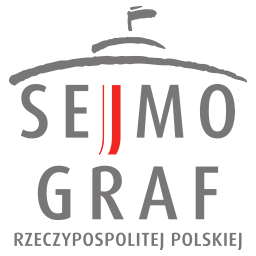


# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/SEJMograf /mydrive

# navigate to the working directory
%cd /mydrive

/content/gdrive/My Drive/Colab Notebooks/SEJMograf


## Libraries & functions
Let's now install missing libraries and import the necessary libraries and functions we're gonna use in this notebook.

- `numpy` - linear algebra
- `pandas` - data manipulation & analysis

In [3]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go

# Load data

In [4]:
df = pd.read_csv('df_clean.csv', index_col=0)
df.head()

,first_name,middle_name,last_name,gender,profile_url,picture,election_date,election_list,election_constituency,election_votes,oath_date,sejm_prl_term_IX,sejm_prl_term_X,sejm_term_I,sejm_term_II,sejm_term_III,sejm_term_IV,sejm_term_V,sejm_term_VI,sejm_term_VII,sejm_term_VIII,senat_term_IX,senat_term_X,senat_term_I,senat_term_II,senat_term_III,senat_term_IV,senat_term_V,senat_term_VI,senat_term_VII,senat_term_VIII,sejm_term_IX,club,birth_date,birth_place,education,school,title,graduation_year,occupation,...,coworker_33,coworker_33_function,coworker_33_info,coworker_34,coworker_34_function,coworker_34_info,coworker_35,coworker_35_function,coworker_35_info,coworker_36,coworker_36_function,coworker_36_info,coworker_37,coworker_37_function,coworker_37_info,coworker_38,coworker_38_function,coworker_38_info,asset_declarations,declaration_01,declaration_01_info,declaration_02,declaration_02_info,benefit_registers,benefit_register_01,benefit_register_01_info,benefit_register_02,benefit_register_02_info,benefit_register_03,benefit_register_03_info,benefit_register_04,benefit_register_04_info,benefit_register_05,benefit_register_05_info,benefit_register_06,benefit_register_06_info,benefit_register_07,benefit_register_07_info,benefit_register_08,benefit_register_08_info
0,Andrzej,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8A510...,2019-10-13,Prawo i Sprawiedliwość,Kraków,29686,2019-11-12,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Prawo i Sprawiedliwość,1959-01-04,Krzeszowice,wyższe,Społeczna Akademia Nauk w Łodzi,licencjat,2014.0,poseł,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/A324231DA1...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/549650FA05...,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Rafał,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8ACA6...,2019-10-13,Sojusz Lewicy Demokratycznej,Katowice,12148,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,"Koalicyjny Klub Parlamentarny Lewicy (Razem, S...",1974-05-30,Dąbrowa Górnicza,wyższe,Politechnika Śląska,NaN,1999.0,samorządowiec,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/DB5AF9B44E...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FAE4951BE...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/EF53E6700...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Piotr,NaN,Adamowicz,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/3CA57...,2019-10-13,Koalicja Obywatelska,Gdańsk,41795,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Koalicja Obywatelska - Plat...,1961-06-26,Elbląg,średnie ogólne,VI LO Gdańsk,NaN,1980.0,dziennikarz/publicysta,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FF94DFF3A...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/2F249C8E3E...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/E7FACBAC8...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Romuald,NaN,Ajchler,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/5E88F...,2019-10-13,Sojusz Lewicy Demokratycznej,Piła,14438,2019-11-12,False,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,

# Explore personal data

## First name

In [5]:
layout = go.Layout(
                   title=go.layout.Title(text='Most frequent first names'),
                   xaxis=go.layout.XAxis(title='Name'),
                   yaxis=go.layout.YAxis(title='Number of occurances')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df['first_name'].value_counts().index[:10],
                       y=df['first_name'].value_counts().values[:10]
                      ),
                layout=layout    
               )
fig.show()

## Last name

In [6]:
layout = go.Layout(
                   title=go.layout.Title(text='Most frequent last names'),
                   xaxis=go.layout.XAxis(title='Last name'),
                   yaxis=go.layout.YAxis(title='Number of occurances')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df['last_name'].value_counts().index[:10],
                       y=df['last_name'].value_counts().values[:10]
                      ),
                layout=layout    
               )
fig.show()

## Gender

In [7]:
df['election_list'].unique()

array(['Prawo i Sprawiedliwość', 'Sojusz Lewicy Demokratycznej',
       'Koalicja Obywatelska', 'Polskie Stronnictwo Ludowe',
       'Konfederacja Wolność i Niepodległość', 'Mniejszość Niemiecka'],
      dtype=object)

In [8]:
layout = go.Layout(
                   title=go.layout.Title(text='Most frequent names'),
                   xaxis=go.layout.XAxis(title='Last name'),
                   yaxis=go.layout.YAxis(title='Number of occurances')
                  )
list_of_parties = df['election_list'].unique()

def barGender(gender):
  df_cropped = df[df['gender'] == gender]
  if gender == 'm':
    name = 'man'
  else:
    name = 'woman'
  x = df_cropped['election_list'].value_counts().index
  y = df_cropped['election_list'].value_counts().values
  bar = go.Bar(
      name = name,
      x = x,
      y = y,
      text = y,
      textposition = 'inside',

  )
  return bar

layout = go.Layout(
                   title=go.layout.Title(text='Gender distribution in political parties'),
                   xaxis=go.layout.XAxis(title='Name of the party'),
                   yaxis=go.layout.YAxis(title='Number of representatives'),
                   barmode = 'stack'
                  )

fig = go.Figure(
    data=[barGender(gender) for gender in df['gender'].unique()],
    layout = layout
    )

fig.show()

# Explore political data

## Election list

In [9]:
labels = df['election_list'].value_counts().index
values = df['election_list'].value_counts().values

layout = go.Layout(
                   title=go.layout.Title(text='Number of representatives')
                  )

fig = go.Figure(                
                go.Pie(
                       labels = labels,
                       values = values,
                       text = labels
                      ),
                layout=layout    
               )
fig.show()

## Election constituency

In [10]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='FindLatLon')

location_coordinates = {
    city:(
        geolocator.geocode(city).latitude,
        geolocator.geocode(city).longitude
        ) for city in df['election_constituency'].unique()
    }

def findLatLon(name, dictionary):
  lat = dictionary[name][0]
  lon = dictionary[name][1]
  return lat, lon

In [11]:
def countPlace(name, column):
  number = len(df[df[column] == name])
  return number

In [12]:
locations = df['election_constituency']
lat = df['election_constituency'].apply(lambda x: findLatLon(x, location_coordinates)[0])
lon = df['election_constituency'].apply(lambda x: findLatLon(x, location_coordinates)[1])
sizes = df['election_constituency'].apply(lambda x: countPlace(x, 'election_constituency'))

mapbox_access_token = open('.mapbox_token').read()


layout = go.Layout(
                   title = go.layout.Title(text='Constituencies'),
                   mapbox=dict(
                       accesstoken = mapbox_access_token,
                       bearing = 0,
                       center = go.layout.mapbox.Center(
                           lat=52.1,
                           lon=19.3
                           ),
                       zoom = 4.5,
                       style = 'dark'
                       ),
                   width = 600,
                   height = 600
)

fig = go.Figure(                
                go.Scattermapbox(
                    lat = lat,
                    lon = lon,
                    mode = 'text+markers',
                    marker = go.scattermapbox.Marker(
                        size=sizes,
                        color='orange',
                        opacity=sizes/np.linalg.norm(sizes),
                        autocolorscale=True,
                        colorbar=None,
                        colorscale='viridis',
                        sizemode='diameter'                    
                        ),                  
                    text = locations,
                    textfont = go.scattermapbox.Textfont(
                        color = 'white',
                        size = 10),
                    textposition = 'bottom center'
                ),
                layout=layout    
               )
fig.show()

In [13]:
def extractCounty(name):
  address = geolocator.geocode(name).address.split(', ')
  for a in address:
    if a.startswith('województwo'):
      county = a
  return county

counties = {
    const:extractCounty(const) for const in df['election_constituency'].unique()
    }

df['election_constituency_county'] = df['election_constituency'].apply(lambda x: counties[x])

In [14]:
layout = go.Layout(
                   title=go.layout.Title(text='Geographical distribution of deputies'),
                   xaxis=go.layout.XAxis(title='County'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df['election_constituency_county'].value_counts().index,
                       y=df['election_constituency_county'].value_counts().values
                      ),
                layout=layout    
               )
fig.show()

In [15]:
locations = df['election_constituency_county']

location_coordinates = {
    city:(
        geolocator.geocode(city).latitude,
        geolocator.geocode(city).longitude
        ) for city in df['election_constituency_county'].unique()
    }

lat = df['election_constituency_county'].apply(lambda x: findLatLon(x, location_coordinates)[0])
lon = df['election_constituency_county'].apply(lambda x: findLatLon(x, location_coordinates)[1])
sizes = df['election_constituency_county'].apply(lambda x: countPlace(x, 'election_constituency_county'))

mapbox_access_token = open('.mapbox_token').read()


layout = go.Layout(
                   title = go.layout.Title(text='Constituencies'),
                   mapbox=dict(
                       accesstoken = mapbox_access_token,
                       bearing = 0,
                       center = go.layout.mapbox.Center(
                           lat=52.1,
                           lon=19.3
                           ),
                       zoom = 4.5,
                       style = 'dark'
                       ),
                   width = 600,
                   height = 600
)

fig = go.Figure(                
                go.Scattermapbox(
                    lat = lat,
                    lon = lon,
                    mode = 'text+markers',
                    marker = go.scattermapbox.Marker(
                        size=sizes,
                        color='orange',
                        opacity=sizes/np.linalg.norm(sizes),
                        autocolorscale=True,
                        colorbar=None,
                        colorscale='viridis',
                        sizemode='diameter'                    
                        ),                  
                    text = locations,
                    textfont = go.scattermapbox.Textfont(
                        color = 'white',
                        size = 10),
                    textposition = 'bottom center'
                ),
                layout=layout    
               )
fig.show()

## Elecition votes

In [27]:
df_tmp = df.groupby('election_list').sum()['election_votes']
df_tmp

layout = go.Layout(
                   title=go.layout.Title(text='Cumulative number of votes'),
                   xaxis=go.layout.XAxis(title='Party'),
                   yaxis=go.layout.YAxis(title='Number of votes')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df_tmp.index,
                       y=df_tmp.values,
                       text=(df_tmp.values/df_tmp.sum())*100, # calculate percentage
                       texttemplate='%{text:.2f}%', # format text output
                       textposition='inside' #text position
                      ),
                layout=layout    
               )
fig.show()

## Individual votes count

In [49]:
layout = go.Layout(
    title = go.layout.Title(text='Election votes'),
    xaxis=dict(
        title='Number of votes',
        # gridcolor='white',
        type='log',
        # gridwidth=2,
        ),
    yaxis=dict(
        title='Party name',
        # gridcolor='white',
        # gridwidth=2,
        )
)

fig = go.Figure(
    data = [
            go.Scatter(
                x=df['election_votes'],
                y=df['election_list'],
                mode='markers',
                text=df['first_name']+' '+df['last_name']
                )
            ],
    layout=layout 
            )

fig.show()

## Votes statistical representation


In [53]:
layout = go.Layout(
    title = go.layout.Title(text='Votes statistical representation'),
    xaxis=dict(
        title='Number of votes',
        type='log'
    )
)

fig = go.Figure(
    data = [
            go.Box(
                x=df[df['election_list']==l]['election_votes'],
                name=l,
                hovertext=l
            ) for l in df['election_list'].unique()
            ],
    layout=layout 
            )

fig.show()

## Service history

### Sejm

In [76]:
sejm_terms = [
    'sejm_prl_term_IX',
    'sejm_prl_term_X',
    'sejm_term_I',
    'sejm_term_II',
    'sejm_term_III',
    'sejm_term_IV',
    'sejm_term_V',
    'sejm_term_VI',
    'sejm_term_VII',
    'sejm_term_VIII',
    'sejm_term_IX'
]
sejm_terms = 
senat_terms = [
    'senat_term_I',
    'senat_term_II',
    'senat_term_III',
    'senat_term_IV',
    'senat_term_V',
    'senat_term_VI',
    'senat_term_VII',
    'senat_term_VIII',
    'senat_term_IX',
    'senat_term_X',   
]             

df_tmp = pd.Series(
    data=(df[df[term]==True].shape[0] for term in sejm_terms),
    index=sejm_terms
    )          	

data = [
        go.Bar(
            x=df_tmp.index,
            y=df_tmp.values,
            # xaxis=dict(
            #     title='Number of votes'
            #     )
            )
        ]

layout = go.Layout(
                   title=go.layout.Title(text='Cumulative number of votes'),
                   xaxis=go.layout.XAxis(title='Party'),
                   yaxis=go.layout.YAxis(title='Number of votes')
                  )
fig = go.Figure(                
                data=data,
                layout=layout    
               )
fig.show()

In [18]:
# https://towardsdatascience.com/geocode-with-python-161ec1e62b89
# https://holypython.com/how-to-create-map-charts-in-python-w-plotly-mapbox/